In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import re

# Load the dataset
df = pd.read_csv("amz_us_price_prediction_dataset.csv").head(200000)
df["title"] = df["title"] + ". " + df["category"]
df = df[["title", "stars", "isBestSeller", "boughtInLastMonth", "price"]].copy()


In [ ]:
# Handle outliers
df = df[df["price"] > 0]  # Remove zero or near-zero prices
df["price"] = np.log1p(df["price"])  # Log-transform target variable

# Encode categorical data
le = LabelEncoder()
df["isBestSeller"] = le.fit_transform(df["isBestSeller"])

# Drop rows with missing values
df.dropna(inplace=True)

# Normalize numerical features (exclude price)
norm = Normalizer()
df[["stars", "boughtInLastMonth"]] = norm.fit_transform(df[["stars", "boughtInLastMonth"]])

# Define tokenizer and build vocabulary
def tokenizer(text):
    return re.findall(r'\b\w+\b', text.lower())

vocab = {"<unk>": 0}
for title in df["title"]:
    tokens = tokenizer(title)
    for token in tokens:
        if token not in vocab:
            vocab[token] = len(vocab)

# Train-test split
training_phase, testing = train_test_split(df, random_state=42, test_size=0.2)
train, val = train_test_split(training_phase, random_state=42, test_size=0.3)


In [ ]:
class PricePredictionDataset(Dataset):
    def __init__(self, data, vocab, tokenizer, numerical_cols, target_col, max_len=50):
        self.data = data
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.numerical_cols = numerical_cols
        self.target_col = target_col
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row["title"]
        numericals = row[self.numerical_cols].values.astype(np.float32)
        price = row[self.target_col]

        tokens = self.tokenizer(text)
        token_indices = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]

        # Pad or truncate
        if len(token_indices) < self.max_len:
            token_indices.extend([self.vocab['<unk>']] * (self.max_len - len(token_indices)))
        else:
            token_indices = token_indices[:self.max_len]

        token_indices = torch.tensor(token_indices, dtype=torch.long)
        numericals = torch.tensor(numericals, dtype=torch.float)
        target = torch.tensor(price, dtype=torch.float)

        return token_indices, numericals, target


In [6]:
numericals = ["stars", "boughtInLastMonth"]
target_col = "price"
max_len = 50

train_dataset = PricePredictionDataset(train, vocab, tokenizer, numerical_cols=numericals, target_col=target_col, max_len=max_len)
val_dataset = PricePredictionDataset(val, vocab, tokenizer, numerical_cols=numericals, target_col=target_col, max_len=max_len)
test_dataset = PricePredictionDataset(testing, vocab, tokenizer, numerical_cols=numericals, target_col=target_col, max_len=max_len)

def collate_fn(batch):
    token_indices = [item[0] for item in batch]
    numericals = torch.stack([item[1] for item in batch])
    targets = torch.stack([item[2] for item in batch])

    token_indices = nn.utils.rnn.pad_sequence(token_indices, batch_first=True, padding_value=vocab['<unk>'])

    return token_indices, numericals, targets

BATCH = 128
train_dl = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_dataset, batch_size=BATCH, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_dataset, batch_size=BATCH, shuffle=False, collate_fn=collate_fn)


In [7]:
class TransformerPricePredictor(nn.Module):
    def __init__(self, vocab_size, embed_size, feat_size, num_heads=4, num_layers=2, hidden_dim=256):
        super(TransformerPricePredictor, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=num_layers)
        self.num_fc = nn.Sequential(
            nn.Linear(feat_size, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_out = nn.Linear(embed_size + hidden_dim, 1)

    def forward(self, x, nums):
        embedded_text = self.embedding(x)
        transformer_out = self.transformer_encoder(embedded_text)
        transformer_out = transformer_out.mean(dim=1)
        num_features = self.num_fc(nums)
        combined = torch.cat((transformer_out, num_features), dim=1)
        price_pred = self.fc_out(combined)
        return price_pred


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model
vocab_size = len(vocab)  # Size of vocabulary
embed_size = 128         # Embedding size
feat_size = len(numericals)  # Number of numerical features
model = TransformerPricePredictor(vocab_size, embed_size, feat_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Ensure evaluate_model is defined
def evaluate_model(model, val_dl, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for token_indices, numericals, targets in val_dl:
            token_indices, numericals, targets = token_indices.to(device), numericals.to(device), targets.to(device)
            outputs = model(token_indices, numericals).squeeze()
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    return val_loss / len(val_dl)

# Training loop with plotting
def train_model_with_plot(model, train_dl, val_dl, optimizer, criterion, epochs=10):
    train_history = []  # Track training loss
    val_history = []    # Track validation loss

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for token_indices, numericals, targets in train_dl:
            token_indices, numericals, targets = token_indices.to(device), numericals.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(token_indices, numericals).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_dl)
        train_history.append(avg_train_loss)

        # Compute validation loss
        val_loss = evaluate_model(model, val_dl, criterion)
        val_history.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Plot Training and Validation Loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_history, label="Train Loss")
    plt.plot(range(1, epochs + 1), val_history, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.grid()
    plt.show()

# Call the training function
train_model_with_plot(model, train_dl, val_dl, optimizer, criterion, epochs=20)

/Users/drpadhaya/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")



Model Evaluation Metrics:
Mean Absolute Error (MAE): 26.5907
Mean Squared Error (MSE): 2497.5146
Root Mean Squared Error (RMSE): 49.9751
R² Score: 0.4295
Accuracy (within ±10.0% tolerance): 18.05%


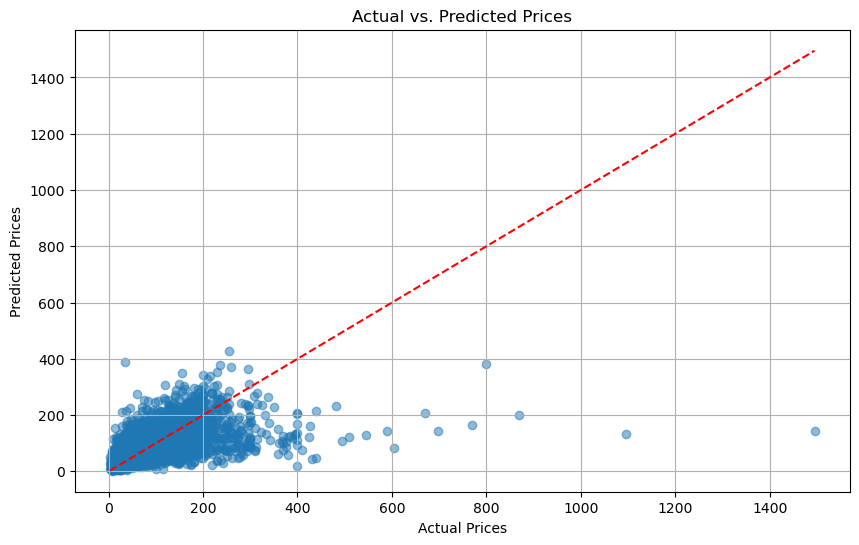

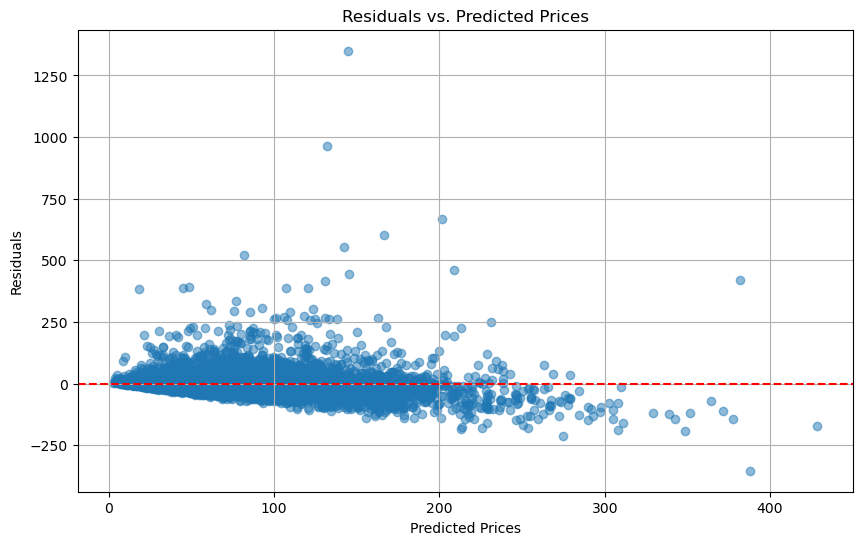

In [40]:
# Evaluation Function with Accuracy
def evaluate_and_plot_with_accuracy(model, test_dl, tolerance=0.1):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for token_indices, numericals, targets in test_dl:
            token_indices, numericals, targets = token_indices.to(device), numericals.to(device), targets.to(device)
            outputs = model(token_indices, numericals).squeeze()
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())

    # Reverse log transformation (if applied earlier)
    predictions_exp = np.expm1(predictions)
    actuals_exp = np.expm1(actuals)

    # Calculate Metrics
    mae = mean_absolute_error(actuals_exp, predictions_exp)
    mse = mean_squared_error(actuals_exp, predictions_exp)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals_exp, predictions_exp)

    # Accuracy Calculation (within ±10% tolerance)
    within_tolerance = np.abs((predictions_exp - actuals_exp) / actuals_exp) <= tolerance
    accuracy = np.mean(within_tolerance) * 100

    print("\nModel Evaluation Metrics:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Accuracy (within ±{tolerance * 100}% tolerance): {accuracy:.2f}%")

    # Plot Actual vs. Predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals_exp, predictions_exp, alpha=0.5)
    plt.plot([min(actuals_exp), max(actuals_exp)], [min(actuals_exp), max(actuals_exp)], color='red', linestyle='--')
    plt.title('Actual vs. Predicted Prices')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.grid()
    plt.show()

    # Plot Residuals
    residuals = actuals_exp - predictions_exp
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions_exp, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals vs. Predicted Prices')
    plt.xlabel('Predicted Prices')
    plt.ylabel('Residuals')
    plt.grid()
    plt.show()

# Evaluate and plot on the test set
evaluate_and_plot_with_accuracy(model, test_dl, tolerance=0.1)
